In [1]:
import numpy as np

In [2]:
import os
import ctypes
import sys


modules_to_clean = []
for name in list(sys.modules.keys()):
    if any(substring in name for substring in ['h5py', 'prometheus', '_hdf5', '_h5py', '_errors']):
        modules_to_clean.append(name)

for mod in modules_to_clean:
    if mod in sys.modules:
        del sys.modules[mod]

# library path
intel_paths = [
    "/software/local/intel/parallel_studio_xe_2020_upd4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64",
    "/software/local/intel/parallel_studio_xe_2020_upd4/compilers_and_libraries_2020.4.304/linux/mkl/lib/intel64",
]

current_ld_path = os.environ.get('LD_LIBRARY_PATH', '')
new_ld_path = ':'.join(intel_paths + [current_ld_path])
os.environ['LD_LIBRARY_PATH'] = new_ld_path

intel_libs = [
    "/software/local/intel/parallel_studio_xe_2020_upd4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64/libimf.so",
    "/software/local/intel/parallel_studio_xe_2020_upd4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64/libintlc.so.5",
    "/software/local/intel/parallel_studio_xe_2020_upd4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64/libsvml.so",
]

for lib_path in intel_libs:
    try:
        ctypes.CDLL(lib_path, mode=ctypes.RTLD_GLOBAL)
        print(f"Successfully preloaded: {lib_path}")
    except Exception as e:
        print(f"Failed to preload {lib_path}: {e}")

# # Python paths
sys.path.insert(0, '/groups/icecube/jackp/prometheus_genie_cleaned/harvard-prometheus')
sys.path.insert(0, '/groups/icecube/jackp/prometheus_genie_cleaned/harvard-prometheus/genie_examples')

try:
    import h5py
    print("✓ h5py imported successfully")
except Exception as e:
    print(f"✗ h5py import failed: {e}")

try:
    from prometheus import Prometheus, config
    print("✓ prometheus imported successfully!")
except Exception as e:
    print(f"✗ prometheus import failed: {e}")
    import traceback
    traceback.print_exc()

Successfully preloaded: /software/local/intel/parallel_studio_xe_2020_upd4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64/libimf.so
Successfully preloaded: /software/local/intel/parallel_studio_xe_2020_upd4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64/libintlc.so.5
Successfully preloaded: /software/local/intel/parallel_studio_xe_2020_upd4/compilers_and_libraries_2020.4.304/linux/compiler/lib/intel64/libsvml.so
✓ h5py imported successfully
✓ prometheus imported successfully!


In [4]:
import pandas as pd
import numpy as np
import time
import sys
import argparse
import os
import logging
from datetime import datetime

sys.path.append('../')
from prometheus import Prometheus, config
import prometheus
import gc

# Import our utility functions
from genie_parser_injection import parse_and_convert_genie

from inject_in_cylinder import inject_particles_in_cylinder
from rotate_particles import rotate_particles_final

# Set up logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
RESOURCE_DIR = f"{'/'.join(prometheus.__path__[0].split('/')[:-1])}/resources/"
OUTPUT_DIR = f"{'/'.join(prometheus.__path__[0].split('/')[:-1])}/genie_examples/output"


In [5]:
import uproot

In [6]:
import pandas as pd
import numpy as np
import uproot

def angle(v1: np.array, v2: np.array) -> float:
    """ Calculates the angle between two vectors in radians

    Parameters
    ----------
    v1: np.array
        vector 1
    v2: np.array
        vector 2

    Returns
    -------
    angle: float
        The calculates angle in radians
    """
    angle = np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1, 1))
    return angle

def p2azimuthAndzenith(p: np.array):
    """ converts a momentum vector to azimuth and zenith angles

    Parameters
    ----------
    p: np.array
        The 3d momentum

    Returns
    -------
    float, float:
        The azimuth and zenith angles in radians.c
    """
    azimuth = angle(p[:2], np.array([0, 1]))
    zenith = angle(p[1:], np.array([0., 1]))
    return azimuth, zenith

def genie_parser(events)->pd.DataFrame:
    """ function to fetch the relevant information from genie events (in rootracker format)

    Parameters
    ----------
    events : dict
        The genie events

    Returns
    -------
    pd.DataFrame
        Data frame containing the relevant information
    """
    dic = {}
    dic['event_description'] = events['EvtCode/fString'].array(library='np')  # String describing the event
    dic['event_id'] = events['EvtNum'].array(library="np")  # Number of the event
    dic['event_children'] = events['StdHepN'].array(library="np")  # NUmber of the generated sub-particles
    dic['event_prob'] = events['EvtProb'].array(library="np")  # Probability of the event
    dic['event_xsec'] = events['EvtXSec'].array(library="np")  # Total xsec of the event
    dic['event_dxsec'] = events['EvtDXSec'].array(library="np")  # Total DXsec of the event
    dic['event_pdg_id'] = events['StdHepPdg'].array(library="np")  # PDG ids of all produced particles
    dic['event_momenta'] = events['StdHepP4'].array(library="np")  # Momenta of the particles
    tmp = events['EvtVtx'].array(library="np")  # Position of the particles
    dic['event_vertex'] = [np.array(vtx) for vtx in tmp]
    dic['event_coords'] = events['StdHepX4'].array(library="np")  # Position of the particles
    dic['event_weight'] = events['EvtWght'].array(library='np')  # Weight of the events
    tmp = events['StdHepStatus'].array(library="np")  # Status of the particle
    # Converting the codes
    particle_dic = {
        0: 'initial',
        1: 'final',
        2: 'intermediate',
        3: 'decayed',
        11: 'nucleon target',
        12: 'DIS pre-frag hadronic state',
        13: 'resonance',
        14: 'hadron in nucleus',
        15: 'final nuclear',
        16: 'nucleon cluster target',
    }
    new_arr = np.array([[
        particle_dic[particle] for particle in event
    ] for event in tmp], dtype=object)
    dic['event_status'] = new_arr
    return pd.DataFrame.from_dict(dic)

def final_parser(parsed_events: pd.DataFrame)->pd.DataFrame:
    """ fetches the final states

    Parameters
    ----------
    parsed_events : pd.DataFrame
        The parsed events

    Returns
    -------
    pd.DataFrame
        The inital + final state info
    """
    inital_energies_inj = np.array([event[0][3] for event in parsed_events['event_momenta']])
    inital_momenta_inj = [np.array(event[0][:3]) for event in parsed_events['event_momenta']]
    inital_energies_target = np.array([event[1][3] for event in parsed_events['event_momenta']])
    inital_id_inj = np.array([event[0] for event in parsed_events['event_pdg_id']])
    inital_id_target = np.array([event[1] for event in parsed_events['event_pdg_id']])
    final_ids = np.array([np.where(event == np.array('final'), True, False) for event in parsed_events['event_status']], dtype=object)
    children_ids = np.array([
        event[final_ids[id_event]] for id_event, event in enumerate(parsed_events['event_pdg_id'])
    ], dtype=object)
    children_energy = np.array([
        event[:, 3][final_ids[id_event]] for id_event, event in enumerate(parsed_events['event_momenta'])
    ], dtype=object)
    children_momenta = np.array([
        event[:, :3][final_ids[id_event]] for id_event, event in enumerate(parsed_events['event_momenta'])
    ], dtype=object)
    final_ids = np.array([np.where(event == np.array('final nuclear'), True, False) for event in parsed_events['event_status']], dtype=object)
    children_nuc_ids = np.array([
        event[final_ids[id_event]] for id_event, event in enumerate(parsed_events['event_pdg_id'])
    ], dtype=object)
    children_nuc_energy = np.array([
        event[:, 3][final_ids[id_event]] for id_event, event in enumerate(parsed_events['event_momenta'])
    ], dtype=object)
    dic = {}
    dic['event_descr'] = parsed_events['event_description']
    dic['event_xsec'] = parsed_events['event_xsec']
    dic['event_dxsec'] =  parsed_events['event_dxsec']
    dic['event_vertex'] = parsed_events.event_vertex
    dic['init_inj_e'] = inital_energies_inj
    dic['init_inj_p'] = inital_momenta_inj
    dic['init_target_e'] = inital_energies_target
    dic['init_inj_id'] = inital_id_inj
    dic['init_target_id'] = inital_id_target
    dic['final_ids'] = children_ids
    dic['final_e'] = children_energy
    dic['final_p'] = children_momenta
    dic['final_nuc_ids'] = children_nuc_ids
    dic['final_nuc_e'] = children_nuc_energy
    dic['p4'] = np.array([event for event in parsed_events['event_momenta']], dtype='object')
    return pd.DataFrame.from_dict(dic)

def genie2prometheus(parsed_events: pd.DataFrame):
    """ reformats parsed GENIE events into a usable format for PROMETHEUS
    NOTES: Create a standardized scheme function. This could then be used as an interface to PROMETHEUS
    for any injector. E.g. a user would only need to create a function to translate their injector output to the scheme format.

    Parameters
    ----------
    parsed_events: pd.DataFrame
        Dataframe object containing all the relevant (and additional) information needed by PROMETHEUS

    Returns
    -------
    particles: pd.DataFrame
        Fromatted data set with values which can be used directly.
    injection: pd.Dataframe
        The injected particle in the same format
    """
    # TODO: Use a more elegant definition to couple to the particle class
    primaries = {}
    event_set  = {}
    for index, event in parsed_events.iterrows():
        if 'CC' in event.event_descr:
            event_type = 'CC'
        elif 'NC' in event.event_descr:
            event_type = 'NC'
        else:
            event_type = 'other'
        azimuth, zenith =  p2azimuthAndzenith(event.init_inj_p)
        primary_particle = {
            "primary": True,  # If this thing is a primary particle
            "e": event.init_inj_e,  # The energy in GeV,  # NOTE: Should this be kinetic energy?
            "pdg_code": event.init_inj_id,  # The PDG id
            "interaction": event_type,  # Should we use ints to define interactions or strings?
            "theta": zenith,  # It's zenith angle
            "phi": azimuth,  # It's azimuth angle
            "bjorken_x": -1,  # Bjorken x variable
            "bjorken_y": -1,  # Bjorken y variable
            "pos_x": event.event_vertex[0],  # position x (in detector coordinates)
            "pos_y": event.event_vertex[1],  # position y (in detector coordinates)
            "pos_z": event.event_vertex[2],  # position z (in detector coordinates)
            "position": event.event_vertex[:3],  # 3d position
            "column_depth": -1,  # Column depth where the interaction happened
            'custom_info': event.event_descr  # Additional information the user can add as a string. # TODO: This should be handed to the propagators
        }
        # TODO: Optimize
        angles = np.array([p2azimuthAndzenith(p) for p in event.final_p])
        particles = {
            "primary": np.array(np.zeros(len(event.final_ids)), dtype=bool),  # If this thing is a primary particle
            "e": event.final_e,  # The energy in GeV,  # NOTE: Should this be kinetic energy?
            "pdg_code": event.final_ids,  # The PDG id
            "interaction": np.array([event_type for _ in range(len(event.final_ids))]),  # Should we use ints to define interactions or strings?
            "theta": angles[:, 1],  # It's zenith angle
            "phi": angles[:, 0],  # It's azimuth angle
            "bjorken_x": np.ones(len(event.final_ids)) * -1,  # Bjorken x variable
            "bjorken_y": np.ones(len(event.final_ids)) * -1,  # Bjorken y variable
            "pos_x": np.ones(len(event.final_ids)) * event.event_vertex[0],  # position x (in detector coordinates)
            "pos_y": np.ones(len(event.final_ids)) * event.event_vertex[1],  # position y (in detector coordinates)
            "pos_z": np.ones(len(event.final_ids)) * event.event_vertex[2],  # position z (in detector coordinates)
            "position": np.array([event.event_vertex[:3] for _ in range(len(event.final_ids))]),  # 3d position
            "column_depth": np.ones(len(event.final_ids)) * -1,  # Column depth where the interaction happened
            'custom_info': np.array(['child' for _ in range(len(event.final_ids))])  # Additional information the user can add as a string. # TODO: This should be handed to the propagators
        }
        event_set[index] = particles
        primaries[index] = primary_particle
    return pd.DataFrame.from_dict(event_set, orient='index'), pd.DataFrame.from_dict(primaries, orient='index')

def parse_and_convert_genie2(root_file_path, inject_in_cylinder=False, rotate_particles = False):
    """Combined function to load, parse and convert GENIE events to Prometheus format
    
    Parameters
    ----------
    root_file_path : str
        Path to the root file containing GENIE events
        
    Returns
    -------
    tuple
        (prometheus_set, primary_set) - DataFrames in Prometheus format
    """
    with uproot.open(root_file_path) as file:
        events = file['gRooTracker']
        parsed_events = genie_parser(events)
        final_parsed = final_parser(parsed_events)
    p1,p2 = genie2prometheus(final_parsed)
    return p1, p2, parsed_events, final_parsed

In [7]:
gtrac_file = "/groups/icecube/jackp/genie_test_outputs/output_gheps/gntp_icecube_numu_100000.gtac.root"

prometheus_set, primary_set,parsed_events, final_parsed = parse_and_convert_genie2(gtrac_file)

2025-05-14 16:44:46,922 - fsspec.local - DEBUG - open file: /groups/icecube/jackp/genie_test_outputs/output_gheps/gntp_icecube_numu_100000.gtac.root
2025-05-14 16:44:46,924 - fsspec.local - DEBUG - open file: /groups/icecube/jackp/genie_test_outputs/output_gheps/gntp_icecube_numu_100000.gtac.root
2025-05-14 16:44:46,959 - fsspec.local - DEBUG - open file: /groups/icecube/jackp/genie_test_outputs/output_gheps/gntp_icecube_numu_100000.gtac.root
2025-05-14 16:44:46,984 - fsspec.local - DEBUG - open file: /groups/icecube/jackp/genie_test_outputs/output_gheps/gntp_icecube_numu_100000.gtac.root
2025-05-14 16:44:47,006 - asyncio - DEBUG - Using selector: EpollSelector
2025-05-14 16:44:47,008 - fsspec.local - DEBUG - open file: /groups/icecube/jackp/genie_test_outputs/output_gheps/gntp_icecube_numu_100000.gtac.root
2025-05-14 16:44:47,008 - fsspec.local - DEBUG - open file: /groups/icecube/jackp/genie_test_outputs/output_gheps/gntp_icecube_numu_100000.gtac.root
2025-05-14 16:44:47,018 - fsspec

In [8]:
primary_set.iloc[99950]

primary                                                      True
e                                                       19.826877
pdg_code                                                       14
interaction                                                    CC
theta                                                         0.0
phi                                                           NaN
bjorken_x                                                      -1
bjorken_y                                                      -1
pos_x                                                         0.0
pos_y                                                         0.0
pos_z                                                         0.0
position                                          [0.0, 0.0, 0.0]
column_depth                                                   -1
custom_info     nu:14;tgt:1000080160;N:2212;q:-2(s);proc:Weak[...
Name: 99950, dtype: object

In [9]:
prometheus_set.iloc[99950]

primary         [False, False, False, False, False, False, False]
e               [0.00993, 18.553675362902467, 1.36991659857184...
pdg_code                     [22, 13, 2112, 211, 2112, 211, 2112]
interaction                          [CC, CC, CC, CC, CC, CC, CC]
theta           [2.1829350811349633, 0.025828734692227354, 0.8...
phi             [3.0065390057546955, 2.129579614370132, 0.7465...
bjorken_x              [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
bjorken_y              [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
pos_x                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
pos_y                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
pos_z                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
position        [[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...
column_depth           [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
custom_info     [child, child, child, child, child, child, child]
Name: 99950, dtype: object

In [10]:
parsed_events.iloc[99950]

event_description    nu:14;tgt:1000080160;N:2212;q:-2(s);proc:Weak[...
event_id                                                         99950
event_children                                                      16
event_prob                                                         0.0
event_xsec                                                    2.189362
event_dxsec                                                   2.823398
event_pdg_id         [14, 1000080160, 2212, 1000070150, 22, 13, 200...
event_momenta        [[0.0, 0.0, 19.82687709074747, 19.826877090747...
event_vertex                                      [0.0, 0.0, 0.0, 0.0]
event_coords         [[0.8352062585394355, -0.047904770700671104, -...
event_weight                                                       1.0
event_status         [initial, initial, nucleon target, intermediat...
Name: 99950, dtype: object

In [11]:
final_parsed.iloc[99950]

event_descr       nu:14;tgt:1000080160;N:2212;q:-2(s);proc:Weak[...
event_xsec                                                 2.189362
event_dxsec                                                2.823398
event_vertex                                   [0.0, 0.0, 0.0, 0.0]
init_inj_e                                                19.826877
init_inj_p                            [0.0, 0.0, 19.82687709074747]
init_target_e                                             14.895081
init_inj_id                                                      14
init_target_id                                           1000080160
final_ids                      [22, 13, 2112, 211, 2112, 211, 2112]
final_e           [0.00993, 18.553675362902467, 1.36991659857184...
final_p           [[-0.00109752646233848, -0.008077127706917498,...
final_nuc_ids                                          [2000000002]
final_nuc_e                                    [12.102593546619937]
p4                [[0.0, 0.0, 19.82687709074747,

In [12]:
prometheus_set.iloc[99950]['pdg_code']

array([  22,   13, 2112,  211, 2112,  211, 2112], dtype=int32)

In [13]:
parsed_events

,event_description,event_id,event_children,event_prob,event_xsec,event_dxsec,event_pdg_id,event_momenta,event_vertex,event_coords,event_weight,event_status
0,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,0,18,2.649229e-15,79.263907,107.219190,"[14, 1000080160, 2112, 1000080150, 13, 2000000...","[[0.0, 0.0, 13.812823237288661, 13.81282323728...","[0.0, 0.0, 0.0, 0.0]","[[-3.6214227812919333, 2.723674812552907, -0.6...",1.0,"[initial, initial, nucleon target, intermediat..."
1,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,1,25,3.340450e-15,99.945001,246.282427,"[14, 1000080160, 2112, 1000080150, 22, 13, 200...","[[0.0, 0.0, 17.177987660805606, 17.17798766080...","[0.0, 0.0, 0.0, 0.0]","[[-0.8521177628398315, 1.0050217365406113, 3.3...",1.0,"[initial, initial, nucleon target, intermediat..."
2,nu:14;tgt:1000010010;N:2212;q:1(v);proc:Weak[C...,2,9,5.136256e-16,7.615137,20.983940,"[14, 2212, 13, 2000000001, 2112, 211, 211, 211...","[[0.0, 0.0, 23.54201578460804, 23.542015784608...","[0.0, 0.0, 0.0, 0.0]","[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...",1.0,"[initial, initial, final, DIS pre-frag hadroni..."
3,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,3,25,2.200113e-15,65.826526,107.210740,"[14, 1000080160, 2112, 1000080150, 13, 2000000...","[[0.0, 0.0, 11.653410944881138, 11.65341094488...","[0.0, 0.0, 0.0, 0.0]","[[0.4737154015594416, 0.6094936929720624, -1.6...",1.0,"[initial, initial, nucleon target, intermediat..."
4,nu:14;tgt:1000080160;N:2212;q:1(s);proc:Weak[C...,4,31,1.256260e-15,37.586830,242.040203,"[14, 1000080160, 2212, 1000070150, 22, 13, 200...","[[0.0, 0.0, 59.02572512597431, 59.025725125974...","[0.0, 0.0, 0.0, 0.0]","[[-0.08654908214113172, 1.1901270980501788, 1....",1.0,"[initial, initial, nucleon target, intermediat..."
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,nu:14;tgt:1000080160;N:2212;q:1(s);proc:Weak[C...,99995,27,7.454593e-16,22.303859,53.081769,"[14, 1000080160, 2212, 1000070150, 13, 2000000...","[[0.0, 0.0, 38.5719917320021, 38.5719917320021...","[0.0, 0.0, 0.0, 0.0]","[[-0.7570098229643845, -0.9414188770090346, 3....",1.0,"[initial, initial, nucleon target, intermediat..."
99996,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,99996,31,8.919343e-15,266.863329,480.556576,"[14, 1000080160, 2112, 1000080150, 13, 2000000...","[[0.0, 0.0, 45.47226963809012, 45.472269638090...","[0.0, 0.0, 0.0, 0.0]","[[1.5915517631976162, -1.9272970370251519, -2....",1.0,"[initial, initial, nucleon target, intermediat..."
99997,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,99997,22,8.674623e-15,259.541407,371.183638,"[14, 1000080160, 2112, 1000080150, 13, 2000000...","[[0.0, 0.0, 44.200577933104725, 44.20057793310...","[0.0, 0.0, 0.0, 0.0]","[[1.1439258662576977, -0.9798234745016366, -0....",1.0,"[initial, initial, nucleon target, intermediat..."
99998,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,99998,25,3.988111e-15,119.322771,132.703418,"[14, 1000080160, 2112, 1000080150, 13, 2000000...","[[0.0, 0.0, 20.365497701426982, 20.36549770142...","[0.0, 0.0, 0.0, 0.0]","[[0.876266762795457, 0.4765750389689564, 1.043...",1.0,"[initial, initial, nucleon target, intermediat..."


In [14]:
final_parsed

,event_descr,event_xsec,event_dxsec,event_vertex,init_inj_e,init_inj_p,init_target_e,init_inj_id,init_target_id,final_ids,final_e,final_p,final_nuc_ids,final_nuc_e,p4
0,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,79.263907,107.219190,"[0.0, 0.0, 0.0, 0.0]",13.812823,"[0.0, 0.0, 13.812823237288661]",14.895081,14,1000080160,"[13, 2112, 2212, 2112, 2112, 2112, 2112, 111]","[12.241536434950843, 1.4266409556002633, 1.001...","[[-0.11087507038055211, 0.4298790041049618, 12...",[2000000002],[9.390915335612824],"[[0.0, 0.0, 13.812823237288661, 13.81282323728..."
1,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,99.945001,246.282427,"[0.0, 0.0, 0.0, 0.0]",17.177988,"[0.0, 0.0, 17.177987660805606]",14.895081,14,1000080160,"[22, 13, 211, 111, 111, 111, 2112, 111]","[0.00618, 11.159845145325475, 3.62720331445329...","[[0.0022983559070700603, 0.003911230912307765,...",[2000000002],[13.966159804665043],"[[0.0, 0.0, 17.177987660805606, 17.17798766080..."
2,nu:14;tgt:1000010010;N:2212;q:1(v);proc:Weak[C...,7.615137,20.983940,"[0.0, 0.0, 0.0, 0.0]",23.542016,"[0.0, 0.0, 23.54201578460804]",0.938272,14,2212,"[13, 2112, 211, 211, 211, -211]","[21.789113939956255, 1.5662808760692444, 0.389...","[[-0.5849501320740836, 0.38577444872688316, 21...",[],[],"[[0.0, 0.0, 23.54201578460804, 23.542015784608..."
3,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,65.826526,107.210740,"[0.0, 0.0, 0.0, 0.0]",11.653411,"[0.0, 0.0, 11.653410944881138]",14.895081,14,1000080160,"[13, 211, 2112, 111, 2112, 2212, 211, -211, 111]","[7.877847294092507, 1.6768188608666141, 1.3446...","[[0.23677424109669812, -0.5796672553786826, 7....",[2000000002],[12.08850145906355],"[[0.0, 0.0, 11.653410944881138, 11.65341094488..."
4,nu:14;tgt:1000080160;N:2212;q:1(s);proc:Weak[C...,37.586830,242.040203,"[0.0, 0.0, 0.0, 0.0]",59.025725,"[0.0, 0.0, 59.02572512597431]",14.895081,14,1000080160,"[22, 13, -321, 211, 311, 211, -321, 321, 2112,...","[0.00368, 5.461169277325859, 4.706355882383697...","[[-0.003428700926378662, -0.001046038652219282...",[2000000002],[13.008128281917836],"[[0.0, 0.0, 59.02572512597431, 59.025725125974..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,nu:14;tgt:1000080160;N:2212;q:1(s);proc:Weak[C...,22.303859,53.081769,"[0.0, 0.0, 0.0, 0.0]",38.571992,"[0.0, 0.0, 38.5719917320021]",14.895081,14,1000080160,"[13, 211, 311, 111, 3122, 111, 211, 111]","[22.145512223674842, 7.743279937131325, 1.9751...","[[-0.5682092838821617, 2.0152104394847146, 22....",[2000000002],[13.970540509371078],"[[0.0, 0.0, 38.5719917320021, 38.5719917320021..."
99996,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,266.863329,480.556576,"[0.0, 0.0, 0.0, 0.0]",45.472270,"[0.0, 0.0, 45.47226963809012]",14.895081,14,1000080160,"[13, 211, -211, 2212, 2212, 2212, 2212, 2212, ...","[25.111969317904236, 11.893406704803642, 2.422...","[[3.0098661895965084, -0.33007880110010834, 24...",[2000000002],[5.491969036190035],"[[0.0, 0.0, 45.47226963809012, 45.472269638090..."
99997,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,259.541407,371.183638,"[0.0, 0.0, 0.0, 0.0]",44.200578,"[0.0, 0.0, 44.200577933104725]",14.895081,14,1000080160,"[13, 211, -211, 321, 3122, -211, 2212]","[28.193112290337744, 8.290402984318426, 2.4995...","[[2.7571702616565528, 0.4372309342705658, 28.0...",[2000000002],[13.032580594261994],"[[0.0, 0.0, 44.200577933104725, 44.20057793310..."
99998,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,119.322771,132.703418,"[0.0, 0.0, 0.0, 0.0]",20.365498,"[0.0, 0.0, 20.365497701426982]",14.895081,14,1000080160,"[13, 22, 22, 211, -211, 111, 2212, 111]","[11.855547741518926, 1.084017729380725, 3.2781...","[[-0.20903015129397715, 1.8705353097957351, 11...",[2000000002],[13.972028762900779],"[[0.0, 0.0, 20.365497701426982, 20.36549770142..."


In [60]:
np.unique(final_parsed[final_parsed['event_xsec']>200]['event_descr'])[0]

'nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[CC],DIS;'

Loaded /groups/icecube/jackp/tmp/dis_cc.csv successfully
Energy range: 0.01 to 100.0
XSec range: 0.0 to 983.268

Loaded /groups/icecube/jackp/tmp/dis_cc_n.csv successfully
Energy range: 0.01 to 100.0
XSec range: 0.0 to 650.228

Loaded /groups/icecube/jackp/tmp/dis_cc_n_dval.csv successfully
Energy range: 0.01 to 100.0
XSec range: 0.0 to 571.91

Loaded /groups/icecube/jackp/tmp/o16_tot_cc.csv successfully
Energy range: 0.01 to 100.0
XSec range: 0.0 to 1085.65

Found 35917 DIS CC events on neutrons in O16


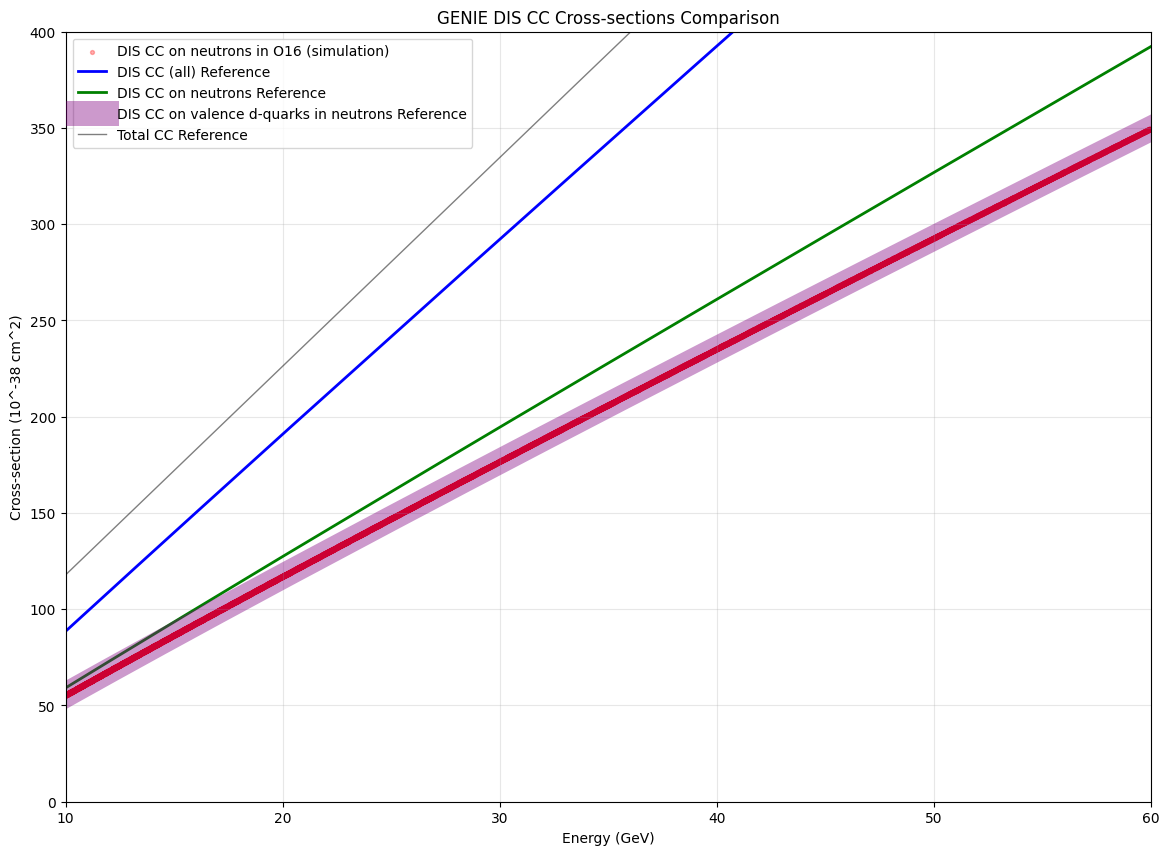


Sample DIS CC event:
Energy: 13.81 GeV
Cross-section: 79.263907
Description: nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[CC],DIS;

Closest reference cross-section (DIS CC n):
Energy: 13.82 GeV
Cross-section: 85.384800
Ratio (simulation/reference): 0.9283


In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the extracted CSV files
csv_dir = "/groups/icecube/jackp/tmp/"  # Adjust path if needed
dis_cc_file = f"{csv_dir}dis_cc.csv"
dis_cc_n_file = f"{csv_dir}dis_cc_n.csv"
dis_cc_n_dval_file = f"{csv_dir}dis_cc_n_dval.csv"
tot_cc_file = f"{csv_dir}o16_tot_cc.csv"  # For comparison

try:
    dis_cc_data = pd.read_csv(dis_cc_file)
    print(f"Loaded {dis_cc_file} successfully")
    print(f"Energy range: {min(dis_cc_data['energy'])} to {max(dis_cc_data['energy'])}")
    print(f"XSec range: {min(dis_cc_data['xsec'])} to {max(dis_cc_data['xsec'])}")
except Exception as e:
    print(f"Error loading {dis_cc_file}: {e}")
    dis_cc_data = None

try:
    dis_cc_n_data = pd.read_csv(dis_cc_n_file)
    print(f"\nLoaded {dis_cc_n_file} successfully")
    print(f"Energy range: {min(dis_cc_n_data['energy'])} to {max(dis_cc_n_data['energy'])}")
    print(f"XSec range: {min(dis_cc_n_data['xsec'])} to {max(dis_cc_n_data['xsec'])}")
except Exception as e:
    print(f"Error loading {dis_cc_n_file}: {e}")
    dis_cc_n_data = None

try:
    dis_cc_n_dval_data = pd.read_csv(dis_cc_n_dval_file)
    print(f"\nLoaded {dis_cc_n_dval_file} successfully")
    print(f"Energy range: {min(dis_cc_n_dval_data['energy'])} to {max(dis_cc_n_dval_data['energy'])}")
    print(f"XSec range: {min(dis_cc_n_dval_data['xsec'])} to {max(dis_cc_n_dval_data['xsec'])}")
except Exception as e:
    print(f"Error loading {dis_cc_n_dval_file}: {e}")
    dis_cc_n_dval_data = None

try:
    tot_cc_data = pd.read_csv(tot_cc_file)
    print(f"\nLoaded {tot_cc_file} successfully")
    print(f"Energy range: {min(tot_cc_data['energy'])} to {max(tot_cc_data['energy'])}")
    print(f"XSec range: {min(tot_cc_data['xsec'])} to {max(tot_cc_data['xsec'])}")
except Exception as e:
    print(f"Error loading {tot_cc_file}: {e}")
    tot_cc_data = None

# Filter events for DIS CC on neutrons
dis_cc_n_mask = (
    final_parsed['event_descr']=='nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[CC],DIS;'
)

dis_cc_n_events = final_parsed[dis_cc_n_mask]
print(f"\nFound {len(dis_cc_n_events)} DIS CC events on neutrons in O16")

# Create a figure
plt.figure(figsize=(14, 10))

# Plot the filtered events
plt.scatter(dis_cc_n_events['init_inj_e'], dis_cc_n_events['event_xsec'], 
            color='red', s=8, alpha=0.3, label='DIS CC on neutrons in O16 (simulation)')

# Plot the reference curves
if dis_cc_data is not None:
    plt.plot(dis_cc_data['energy'], dis_cc_data['xsec'], 
             '-', color='blue', linewidth=2, label='DIS CC (all) Reference')

if dis_cc_n_data is not None:
    plt.plot(dis_cc_n_data['energy'], dis_cc_n_data['xsec'], 
             '-', color='green', linewidth=2, label='DIS CC on neutrons Reference')

if dis_cc_n_dval_data is not None:
    plt.plot(dis_cc_n_dval_data['energy'], dis_cc_n_dval_data['xsec'], 
             '-', color='purple', linewidth=18, alpha =0.4, label='DIS CC on valence d-quarks in neutrons Reference')

if tot_cc_data is not None:
    plt.plot(tot_cc_data['energy'], tot_cc_data['xsec'], 
             '-', color='black', linewidth=1, alpha=0.5, label='Total CC Reference')

# Add labels and finalize the plot
plt.xlabel('Energy (GeV)')
plt.ylabel('Cross-section (10^-38 cm^2)')
plt.title('GENIE DIS CC Cross-sections Comparison')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(10, 60)
plt.ylim(0, 400)  # Adjust as needed
plt.show()

# Sample event for reference
print("\nSample DIS CC event:")
if len(dis_cc_n_events) > 0:
    sample_event = dis_cc_n_events.iloc[0]
    print(f"Energy: {sample_event['init_inj_e']:.2f} GeV")
    print(f"Cross-section: {sample_event['event_xsec']:.6f}")
    print(f"Description: {sample_event['event_descr']}")
    
    # Find the closest energy in the reference data
    if dis_cc_n_data is not None:
        closest_idx = np.abs(dis_cc_n_data['energy'] - sample_event['init_inj_e']).argmin()
        reference_xsec = dis_cc_n_data['xsec'][closest_idx]
        print(f"\nClosest reference cross-section (DIS CC n):")
        print(f"Energy: {dis_cc_n_data['energy'][closest_idx]:.2f} GeV")
        print(f"Cross-section: {reference_xsec:.6f}")
        print(f"Ratio (simulation/reference): {sample_event['event_xsec'] / reference_xsec:.4f}")

In [56]:
dis_cc_n_events

,event_descr,event_xsec,event_dxsec,event_vertex,init_inj_e,init_inj_p,init_target_e,init_inj_id,init_target_id,final_ids,final_e,final_p,final_nuc_ids,final_nuc_e,p4
0,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,79.263907,107.219190,"[0.0, 0.0, 0.0, 0.0]",13.812823,"[0.0, 0.0, 13.812823237288661]",14.895081,14,1000080160,"[13, 2112, 2212, 2112, 2112, 2112, 2112, 111]","[12.241536434950843, 1.4266409556002633, 1.001...","[[-0.11087507038055211, 0.4298790041049618, 12...",[2000000002],[9.390915335612824],"[[0.0, 0.0, 13.812823237288661, 13.81282323728..."
1,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,99.945001,246.282427,"[0.0, 0.0, 0.0, 0.0]",17.177988,"[0.0, 0.0, 17.177987660805606]",14.895081,14,1000080160,"[22, 13, 211, 111, 111, 111, 2112, 111]","[0.00618, 11.159845145325475, 3.62720331445329...","[[0.0022983559070700603, 0.003911230912307765,...",[2000000002],[13.966159804665043],"[[0.0, 0.0, 17.177987660805606, 17.17798766080..."
2,nu:14;tgt:1000010010;N:2212;q:1(v);proc:Weak[C...,7.615137,20.983940,"[0.0, 0.0, 0.0, 0.0]",23.542016,"[0.0, 0.0, 23.54201578460804]",0.938272,14,2212,"[13, 2112, 211, 211, 211, -211]","[21.789113939956255, 1.5662808760692444, 0.389...","[[-0.5849501320740836, 0.38577444872688316, 21...",[],[],"[[0.0, 0.0, 23.54201578460804, 23.542015784608..."
3,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,65.826526,107.210740,"[0.0, 0.0, 0.0, 0.0]",11.653411,"[0.0, 0.0, 11.653410944881138]",14.895081,14,1000080160,"[13, 211, 2112, 111, 2112, 2212, 211, -211, 111]","[7.877847294092507, 1.6768188608666141, 1.3446...","[[0.23677424109669812, -0.5796672553786826, 7....",[2000000002],[12.08850145906355],"[[0.0, 0.0, 11.653410944881138, 11.65341094488..."
4,nu:14;tgt:1000080160;N:2212;q:1(s);proc:Weak[C...,37.586830,242.040203,"[0.0, 0.0, 0.0, 0.0]",59.025725,"[0.0, 0.0, 59.02572512597431]",14.895081,14,1000080160,"[22, 13, -321, 211, 311, 211, -321, 321, 2112,...","[0.00368, 5.461169277325859, 4.706355882383697...","[[-0.003428700926378662, -0.001046038652219282...",[2000000002],[13.008128281917836],"[[0.0, 0.0, 59.02572512597431, 59.025725125974..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,nu:14;tgt:1000080160;N:2212;q:1(s);proc:Weak[C...,22.303859,53.081769,"[0.0, 0.0, 0.0, 0.0]",38.571992,"[0.0, 0.0, 38.5719917320021]",14.895081,14,1000080160,"[13, 211, 311, 111, 3122, 111, 211, 111]","[22.145512223674842, 7.743279937131325, 1.9751...","[[-0.5682092838821617, 2.0152104394847146, 22....",[2000000002],[13.970540509371078],"[[0.0, 0.0, 38.5719917320021, 38.5719917320021..."
99996,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,266.863329,480.556576,"[0.0, 0.0, 0.0, 0.0]",45.472270,"[0.0, 0.0, 45.47226963809012]",14.895081,14,1000080160,"[13, 211, -211, 2212, 2212, 2212, 2212, 2212, ...","[25.111969317904236, 11.893406704803642, 2.422...","[[3.0098661895965084, -0.33007880110010834, 24...",[2000000002],[5.491969036190035],"[[0.0, 0.0, 45.47226963809012, 45.472269638090..."
99997,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,259.541407,371.183638,"[0.0, 0.0, 0.0, 0.0]",44.200578,"[0.0, 0.0, 44.200577933104725]",14.895081,14,1000080160,"[13, 211, -211, 321, 3122, -211, 2212]","[28.193112290337744, 8.290402984318426, 2.4995...","[[2.7571702616565528, 0.4372309342705658, 28.0...",[2000000002],[13.032580594261994],"[[0.0, 0.0, 44.200577933104725, 44.20057793310..."
99998,nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...,119.322771,132.703418,"[0.0, 0.0, 0.0, 0.0]",20.365498,"[0.0, 0.0, 20.365497701426982]",14.895081,14,1000080160,"[13, 22, 22, 211, -211, 111, 2212, 111]","[11.855547741518926, 1.084017729380725, 3.2781...","[[-0.20903015129397715, 1.8705353097957351, 11...",[2000000002],[13.972028762900779],"[[0.0, 0.0, 20.365497701426982, 20.36549770142..."


In [15]:
parsed_events.iloc[99950]

event_description    nu:14;tgt:1000080160;N:2212;q:-2(s);proc:Weak[...
event_id                                                         99950
event_children                                                      16
event_prob                                                         0.0
event_xsec                                                    2.189362
event_dxsec                                                   2.823398
event_pdg_id         [14, 1000080160, 2212, 1000070150, 22, 13, 200...
event_momenta        [[0.0, 0.0, 19.82687709074747, 19.826877090747...
event_vertex                                      [0.0, 0.0, 0.0, 0.0]
event_coords         [[0.8352062585394355, -0.047904770700671104, -...
event_weight                                                       1.0
event_status         [initial, initial, nucleon target, intermediat...
Name: 99950, dtype: object

In [16]:
final_parsed.iloc[99950]

event_descr       nu:14;tgt:1000080160;N:2212;q:-2(s);proc:Weak[...
event_xsec                                                 2.189362
event_dxsec                                                2.823398
event_vertex                                   [0.0, 0.0, 0.0, 0.0]
init_inj_e                                                19.826877
init_inj_p                            [0.0, 0.0, 19.82687709074747]
init_target_e                                             14.895081
init_inj_id                                                      14
init_target_id                                           1000080160
final_ids                      [22, 13, 2112, 211, 2112, 211, 2112]
final_e           [0.00993, 18.553675362902467, 1.36991659857184...
final_p           [[-0.00109752646233848, -0.008077127706917498,...
final_nuc_ids                                          [2000000002]
final_nuc_e                                    [12.102593546619937]
p4                [[0.0, 0.0, 19.82687709074747,

In [17]:
final_parsed.iloc[99950]['event_descr']

'nu:14;tgt:1000080160;N:2212;q:-2(s);proc:Weak[CC],DIS;'

In [49]:
final_parsed.columns

Index(['event_descr', 'event_xsec', 'event_dxsec', 'event_vertex',
       'init_inj_e', 'init_inj_p', 'init_target_e', 'init_inj_id',
       'init_target_id', 'final_ids', 'final_e', 'final_p', 'final_nuc_ids',
       'final_nuc_e', 'p4'],
      dtype='object')

In [19]:
parsed_events.columns

Index(['event_description', 'event_id', 'event_children', 'event_prob',
       'event_xsec', 'event_dxsec', 'event_pdg_id', 'event_momenta',
       'event_vertex', 'event_coords', 'event_weight', 'event_status'],
      dtype='object')

In [20]:
event_xsec = np.array(final_parsed['event_xsec'])
event_dxsec = np.array(final_parsed['event_dxsec'])
event_e = np.array(final_parsed['init_inj_e'])

In [54]:
np.unique(final_parsed[final_parsed['event_xsec']> 200]['event_descr'])

array(['nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[CC],DIS;'],
      dtype=object)

In [50]:
final_parsed['event_descr']

0        nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...
1        nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...
2        nu:14;tgt:1000010010;N:2212;q:1(v);proc:Weak[C...
3        nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...
4        nu:14;tgt:1000080160;N:2212;q:1(s);proc:Weak[C...
                               ...                        
99995    nu:14;tgt:1000080160;N:2212;q:1(s);proc:Weak[C...
99996    nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...
99997    nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...
99998    nu:14;tgt:1000080160;N:2112;q:1(v);proc:Weak[C...
99999    nu:14;tgt:1000080160;N:2212;q:-2(s);proc:Weak[...
Name: event_descr, Length: 100000, dtype: object

2025-05-14 16:46:07,260 - matplotlib - DEBUG - matplotlib data path: /groups/icecube/jackp/.conda/envs/myenv/lib/python3.9/site-packages/matplotlib/mpl-data
2025-05-14 16:46:07,293 - matplotlib - DEBUG - CONFIGDIR=/groups/icecube/jackp/.config/matplotlib
2025-05-14 16:46:07,320 - matplotlib - DEBUG - interactive is False
2025-05-14 16:46:07,321 - matplotlib - DEBUG - platform is linux
2025-05-14 16:46:07,816 - matplotlib - DEBUG - CACHEDIR=/groups/icecube/jackp/.cache/matplotlib
2025-05-14 16:46:07,838 - matplotlib.font_manager - DEBUG - Using fontManager instance from /groups/icecube/jackp/.cache/matplotlib/fontlist-v390.json
2025-05-14 16:46:09,774 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-14 16:46:09,775 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-05-14 16:46:09,777 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:varia

[]

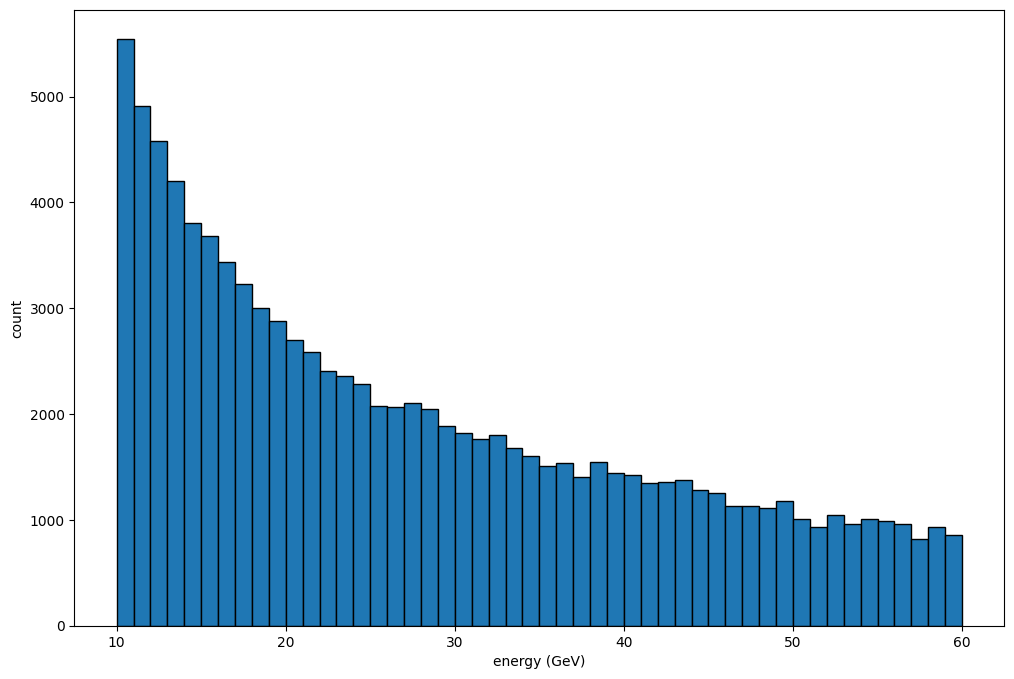

In [22]:
import matplotlib.pyplot as plt
e_bins = np.linspace(10, 60, 51)
plt.figure(figsize=(12,8))
plt.hist(event_e, edgecolor='black', bins = e_bins)
plt.xlabel('energy (GeV)')
plt.ylabel('count')
plt.plot()

[]

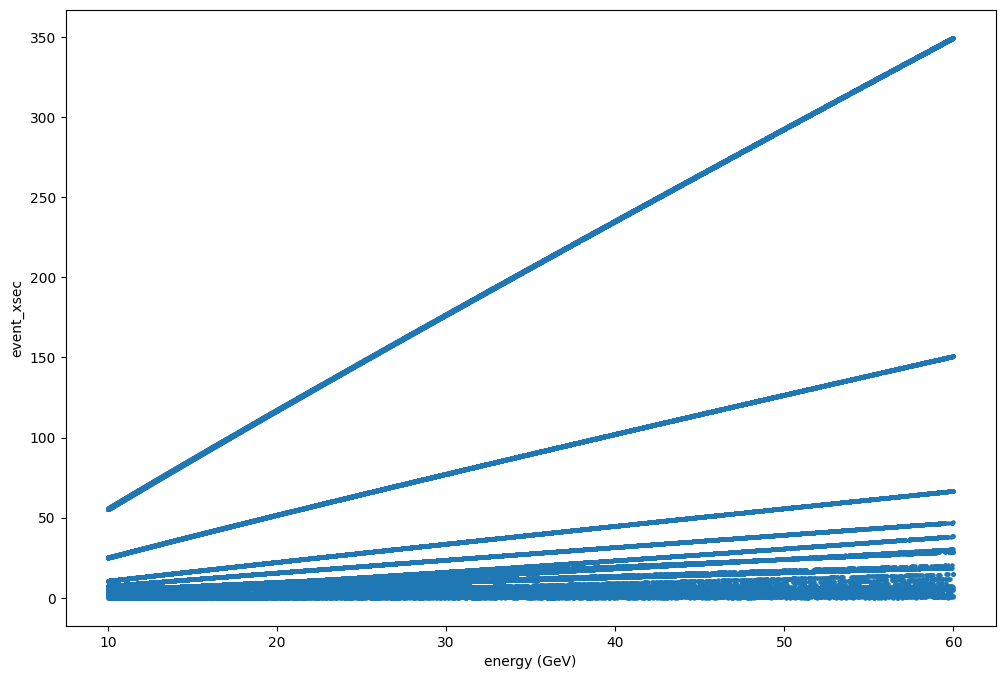

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.scatter(event_e, event_xsec, s=5)
plt.xlabel('energy (GeV)')
plt.ylabel('event_xsec')
plt.plot()

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Paths to your CSV files
csv_dir = "/groups/icecube/jackp/tmp/"
o16_files = {
    'tot_cc': f"{csv_dir}o16_tot_cc.csv",
    'tot_nc': f"{csv_dir}o16_tot_nc.csv",
    'tot_cc_p': f"{csv_dir}o16_tot_cc_p.csv",
    'tot_cc_n': f"{csv_dir}o16_tot_cc_n.csv",
    'tot_nc_p': f"{csv_dir}o16_tot_nc_p.csv",
    'tot_nc_n': f"{csv_dir}o16_tot_nc_n.csv"
}

h1_files = {
    'tot_cc': f"{csv_dir}h1_tot_cc.csv",
    'tot_nc': f"{csv_dir}h1_tot_nc.csv",
    'tot_cc_p': f"{csv_dir}h1_tot_cc_p.csv",
    'tot_cc_n': f"{csv_dir}h1_tot_cc_n.csv",
    'tot_nc_p': f"{csv_dir}h1_tot_nc_p.csv",
    'tot_nc_n': f"{csv_dir}h1_tot_nc_n.csv"
}

# Load data from CSV files
o16_data = {}
for name, file in o16_files.items():
    try:
        df = pd.read_csv(file)
        o16_data[name] = {
            'energy': df['energy'].values,
            'xsec': df['xsec'].values
        }
    except Exception as e:
        print(f"Error loading {file}: {e}")

h1_data = {}
for name, file in h1_files.items():
    try:
        df = pd.read_csv(file)
        h1_data[name] = {
            'energy': df['energy'].values,
            'xsec': df['xsec'].values
        }
    except Exception as e:
        print(f"Error loading {file}: {e}")
